<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/05b_Aprendizagem_Auto_Supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizagem Auto-Supervisionada

No self-supervised learning, o modelo resolve tarefas de pretexto — tarefas auxiliares geradas automaticamente a partir dos próprios dados, como a predição de partes mascaradas, reconstrução de imagens ou a aprendizagem de similaridades entre amostras. Durante a aula, discutiremos tópicos como autoencoders, masked autoencoders, e técnicas poderosas de aprendizado contrastivo, como SimCLR e MoCo. Além disso, veremos como modelos como o BERT utilizam essas ideias no processamento de linguagem natural e como isso impulsiona o desenvolvimento de soluções de ponta sem a necessidade de grandes quantidades de dados rotulados.


## Autoencoders

Autoencoders são modelos projetados para aprender representações dos dados ao tentar reconstruir a entrada original a partir de uma codificação latente. Eles funcionam sem a necessidade de rótulos, utilizando a própria estrutura dos dados como supervisão, tornando-os extremamente úteis para tarefas como compressão, remoção de ruído e geração de dados. Estes modelos foram introduzidos bem antes da definição formal de self-supervised learning, mas seu princípio de utilizar os próprios dados como supervisão se alinha perfeitamente com esse paradigma.


### Autoencoder Clássico

Os autoencoders são um tipo de rede neural projetada para aprender uma representação compacta dos dados, também conhecida como codificação latente, de forma não supervisionada. Uma das suas primeiras idéias surgiu na década de 1980 por Geoffrey Hinton. Eles são compostos por duas partes principais: o codificador, que reduz a dimensionalidade dos dados de entrada ao projetá-los em um espaço latente de menor dimensão, e o decodificador, que tenta reconstruir os dados originais a partir dessa representação comprimida. A principal aplicação dos autoencoders está em tarefas como redução de dimensionalidade, remoção de ruído e geração de novas amostras.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/ae.jpg?raw=true" width=500></center>

A avaliação de autoencoders geralmente é feita comparando a similaridade entre os dados de entrada e sua reconstrução gerada pelo decodificador, utilizando métricas como erro quadrático médio (MSE) ou entropia cruzada, dependendo do tipo de dados. O objetivo é minimizar essa diferença, o que indica que o autoencoder aprendeu uma boa representação latente. A otimização dos autoencoders é realizada através de técnicas padrão de redes neurais, como a _backpropagation_ e o uso de algoritmos de otimização, como o gradiente descendente e suas variantes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Variantes de Autoencoder

Entre as variações dos autoencoders, o **Denoising Autoencoder** merece destaque por sua capacidade de aprender representações robustas ao ruído. Diferente do autoencoder tradicional, ele é treinado para reconstruir a versão original de uma entrada corrompida, o que o torna ideal para tarefas de remoção de ruído e aprendizado de características mais estáveis dos dados (Vincent et al., 2008).

Outro tipo importante é o **Stacked Autoencoder**, que consiste em uma rede mais profunda, onde várias camadas de autoencoders são empilhadas (Hinton & Salakhutdinov, 2006). Isso permite que o modelo aprenda representações hierárquicas, capturando características de baixo e alto nível dos dados. Ao empilhar múltiplos autoencoders, o modelo pode capturar padrões mais complexos e abstrações, sendo amplamente utilizado em pré-treinamento de redes neurais profundas.

## Exemplo: Reconstrução de Dados com MNIST

In [ ]:
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
batch_size = 64
latent_dim = 20
lr = 0.0002
epochs = 5

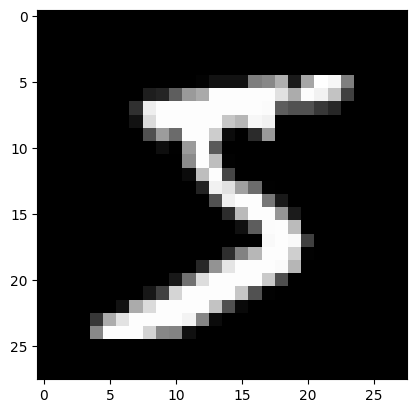

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

plt.imshow(dataset[0][0][0], cmap='gray')
plt.show()

In [ ]:
ae = Autoencoder(input_size=28*28)
optimizer = optim.Adam(ae.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(epochs):
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1)
        recon = ae(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

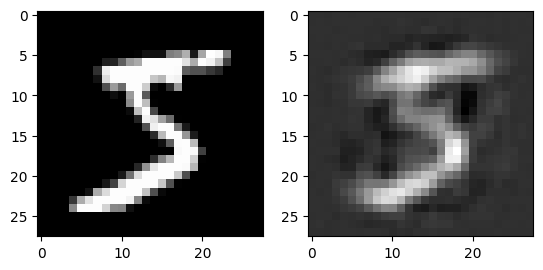

In [ ]:
fig, axs = plt.subplots(1,2)
output = ae(dataset[0][0].flatten())
axs[0].imshow(dataset[0][0][0].numpy(), cmap='gray')
axs[1].imshow(output.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

## Tarefas de Pretexto

As tarefas de pretexto em self-supervised learning são estratégias que visam gerar automaticamente rótulos a partir dos próprios dados, eliminando a necessidade de grandes volumes de anotações manuais. Essas tarefas utilizam informações inerentes à estrutura dos dados para criar objetivos intermediários, também conhecidos como pretext tasks, que forçam o modelo a aprender representações úteis. Entre os exemplos mais comuns estão a predição da rotação de uma imagem, o preenchimento de regiões ocultas ou a ordenação de sequências temporais. Ao treinar o modelo para resolver essas tarefas artificiais, espera-se que ele capture características robustas e generalizáveis, que podem ser posteriormente aproveitadas para outras tarefas supervisionadas ou não supervisionadas.

### Idéias Iniciais

As ideias iniciais de self-supervised learning surgiram da necessidade de superar a dependência de grandes quantidades de dados rotulados, que podem ser caros e demorados para se obter. Inspirado por conceitos do aprendizado não supervisionado, o self-supervised learning propõe a criação de tarefas auxiliares onde o próprio dado supervisiona o aprendizado, gerando rótulos a partir de informações intrínsecas aos dados. A motivação por trás dessas abordagens é que, ao explorar padrões e estruturas subjacentes aos dados, o modelo pode aprender representações mais ricas e generalizáveis. Essas primeiras ideias marcaram o início de um campo promissor, que buscava alavancar a abundância de dados não rotulados disponíveis em diversos domínios.

A tarefa de **jigsaw puzzle** em self-supervised learning envolve dividir uma imagem em várias partes e embaralhá-las, de modo que o modelo seja treinado para rearranjar corretamente essas partes na posição original. Introduzida como uma tarefa de pretexto por Noroozi e Favaro em 2016, essa abordagem força o modelo a entender as relações espaciais e contextuais entre diferentes regiões da imagem. Ao resolver o puzzle, o modelo aprende representações que capturam características locais e globais da imagem, tornando-se capaz de generalizar para tarefas visuais supervisionadas, como detecção de objetos e segmentação.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/jigsaw.JPG?raw=true" width=500></center>

A colorização de imagens em self-supervised learning é uma tarefa de pretexto onde o modelo é treinado para converter uma imagem em tons de cinza para sua versão colorida. Esse método foi popularizado por Zhang et al.  em 2016. A ideia é que, ao tentar prever as cores corretas para cada pixel da imagem, o modelo seja forçado a aprender representações ricas e semânticas, capturando informações sobre a forma, textura e composição dos objetos na cena. Esse aprendizado implícito ajuda a desenvolver uma compreensão visual profunda que pode ser transferida para outras tarefas supervisionadas, como reconhecimento de objetos e classificação de imagens.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/colorize.JPG?raw=true" width=500></center>

A **predição de rotação de imagens** é uma tarefa comum em self-supervised learning, onde o modelo é treinado para identificar a rotação aplicada a uma imagem (0°, 90°, 180°, ou 270°). Essa tarefa simples força o modelo a aprender características visuais robustas e discriminativas das imagens, como formas, texturas e orientações, sem a necessidade de rótulos manuais (Gidaris et al., 2018). Ao resolver essa tarefa, o modelo é capaz de capturar representações que podem ser transferidas para outras tarefas supervisionadas, como classificação ou detecção de objetos.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/rotation.JPG?raw=true" width=500></center>

### Masked Language Modelling

O masked language modeling (MLM) é uma técnica fundamental em self-supervised learning aplicada ao processamento de linguagem natural (PLN), popularizada pelo modelo BERT (2018). Nesse método, partes de uma sentença são mascaradas aleatoriamente, e o modelo é treinado para prever as palavras ocultas com base no contexto fornecido pelas palavras visíveis. Essa abordagem permite que o modelo capture relações bidirecionais dentro da sequência, compreendendo melhor a semântica e a sintaxe do texto. O MLM é uma tarefa eficaz para o aprendizado de representações linguísticas robustas, que podem ser aplicadas a uma ampla gama de tarefas de PLN supervisionadas, como classificação de texto, tradução e resposta a perguntas.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/bert.jpg?raw=true" width=700></center>

### Masked Autoencoders

Masked autoencoders (MAE) são uma técnica aplicada principalmente à área de visão computacional. Nesse método, partes significativas da entrada, como pixels em uma imagem, são mascaradas aleatoriamente, e o modelo é treinado para reconstruir essas regiões ocultas a partir das partes visíveis. Introduzido por He et al. em 2021, o MAE se inspira na ideia do masked language modeling, mas adapta o conceito para domínios visuais. Através dessa tarefa de reconstrução, o modelo aprende representações visuais ricas e eficientes, capazes de capturar tanto detalhes locais quanto estruturas globais, sendo especialmente útil para tarefas supervisionadas subsequentes, como classificação e detecção de objetos.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/masked_autoencoder.JPG?raw=true" width=500></center>

## Contrastive Learning

Contrastive learning é uma abordagem poderosa em self-supervised learning que busca aprender representações discriminativas, aproximando exemplos similares e afastando exemplos diferentes no espaço de representação. A ideia central é que, para cada amostra de dados, o modelo deve identificar quais outras amostras são mais parecidas, formando pares positivos (semelhantes) e negativos (diferentes). Métodos como SimCLR e MoCo popularizaram essa técnica, utilizando diferentes formas de gerar amostras positivas e negativas, como augumentações de dados ou o uso de instâncias diferentes. Contrastive learning está intimamente relacionado a Siamese Networks, uma arquitetura que também trabalha com pares de entradas, comparando similaridades entre elas para aprender representações. O aprendizado contrastivo é eficaz porque ensina o modelo a identificar características intrínsecas dos dados, resultando em representações robustas e generalizáveis para uma variedade de tarefas supervisionadas, sem a necessidade de rótulos manuais.

### SimCLR

SimCLR (Simple Framework for Contrastive Learning of Visual Representations) é uma abordagem de self-supervised learning apresentada pela equipe do Google Research em 2020, que simplifica o aprendizado contrastivo ao dispensar a necessidade de memória complexa ou redes de professores, como usadas em métodos anteriores. Em SimCLR, uma imagem é transformada por meio de diferentes augmentações (como rotação, corte ou alteração de cores), criando duas versões da mesma imagem. O modelo é então treinado para maximizar a similaridade entre essas duas versões (par positivo), enquanto minimiza a similaridade em relação a outras imagens (pares negativos). SimCLR também introduz o uso de um projection head, uma pequena rede neural que mapeia as representações aprendidas para um espaço latente adequado para o cálculo da perda contrastiva. Através desse processo, o modelo aprende representações visuais generalizáveis que podem ser transferidas para tarefas supervisionadas com excelente desempenho, especialmente em cenários com poucos dados rotulados.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/simclr.JPG?raw=true" width=400></center>

### MoCo

MoCo (Momentum Contrast) é uma técnica de self-supervised learning baseada em aprendizado contrastivo, desenvolvida pela equipe da Facebook AI Research e apresentada em 2020. A principal inovação do MoCo é o uso de uma fila dinâmica e um mecanismo de atualização por momentum para construir um banco de memória consistente para as representações de amostras negativas, superando limitações de métodos anteriores, como a necessidade de grandes lotes para o cálculo das perdas contrastivas. MoCo utiliza duas redes neurais: uma rede principal e uma rede auxiliar de momentum, onde a segunda é uma versão suavizada da primeira, atualizada gradualmente com os pesos da rede principal, garantindo maior estabilidade no treinamento. Essa abordagem resulta em representações visuais de alta qualidade que podem ser transferidas eficientemente para tarefas supervisionadas, como classificação e detecção de objetos.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/moco.JPG?raw=true" width=400></center>

### BYOL

BYOL (Bootstrap Your Own Latent) é uma abordagem de self-supervised learning introduzida pela equipe do DeepMind em 2020, que se destaca por eliminar a necessidade de pares negativos, comuns em métodos de aprendizado contrastivo como SimCLR e MoCo. BYOL utiliza duas redes neurais, chamadas de online e target networks, onde a online network é treinada para prever a representação da target network. A target network é uma cópia suavizada da online network, atualizada por um mecanismo de momentum. Ao contrário de métodos contrastivos tradicionais, BYOL apenas maximiza a similaridade entre duas versões da mesma imagem, sem comparar com imagens diferentes. Esse processo, chamado de bootstrapping, permite que o modelo aprenda representações ricas sem a necessidade de pares negativos, alcançando resultados de ponta em tarefas de visão computacional, mesmo com poucos dados rotulados.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/byol.JPG?raw=true" width=700></center>

### Supervised Contrastive Learning

Supervised Contrastive Learning é uma extensão do aprendizado contrastivo tradicional que aproveita dados rotulados para melhorar o processo de aprendizado de representações. Introduzido pela equipe do Google Research em 2020, esse método aplica a lógica do contraste não apenas entre pares positivos gerados por augmentações de dados, mas também entre exemplos da mesma classe. No supervised contrastive learning, o objetivo é maximizar a similaridade entre amostras que compartilham o mesmo rótulo, enquanto se minimiza a similaridade entre amostras de classes diferentes. Essa abordagem permite que o modelo explore melhor as relações entre as categorias nos dados, resultando em representações mais discriminativas e robustas. Além disso, ele proporciona ganhos de desempenho em comparação com os métodos tradicionais supervisionados, como o uso da entropia cruzada para classificação, especialmente em cenários de classificação com múltiplas classes e em datasets com grande diversidade.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/scl.JPG?raw=true" width=500></center>

# Exercícios

1. Discuta como pré-treino utilizando self-supervised learning é capaz de melhorar resultados de modelos supervisionados.
2. Encontre aplicações recentes de como self-supervised learning vem sendo utilizado em aplicações práticas.

# Considerações Finais

Neste capítulo, abordamos paradigmas diferentes para treino de redes neurais artificiais. Ao invés de utilizar dados anotados, utilizamos os próprios dados de diversas formas diferentes para realizar o que chamamos de treino auto-supervisionado.

## Próximo Capítulo

No próximo capítulo, veremos modelos focados em geração de dados, como:

- Variational Autoencoders
- Generative Adversarial Neural Networks

# Referências

- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning internal representations by error propagation. Parallel distributed processing, explorations in the microstructure of cognition.
- Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). Extracting and composing robust features with denoising autoencoders. In Proceedings of the 25th international conference on Machine learning (pp. 1096-1103).
- Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. science, 313(5786), 504-507.
- Noroozi, M., & Favaro, P. (2016, September). Unsupervised learning of visual representations by solving jigsaw puzzles. In European conference on computer vision (pp. 69-84). Cham: Springer International Publishing.
- Zhang, R., Isola, P., & Efros, A. A. (2016). Colorful image colorization. In Computer Vision–ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11-14, 2016, Proceedings, Part III 14 (pp. 649-666). Springer International Publishing.
- Gidaris, S., Singh, P., & Komodakis, N. (2018). Unsupervised representation learning by predicting image rotations. arXiv preprint arXiv:1803.07728.
- Devlin, J. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.
- He, K., Chen, X., Xie, S., Li, Y., Dollár, P., & Girshick, R. (2022). Masked autoencoders are scalable vision learners. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 16000-16009).
- Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020, November). A simple framework for contrastive learning of visual representations. In International conference on machine learning (pp. 1597-1607). PMLR.
- He, K., Fan, H., Wu, Y., Xie, S., & Girshick, R. (2020). Momentum contrast for unsupervised visual representation learning. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 9729-9738).
- Grill, J. B., Strub, F., Altché, F., Tallec, C., Richemond, P., Buchatskaya, E., ... & Valko, M. (2020). Bootstrap your own latent-a new approach to self-supervised learning. Advances in neural information processing systems, 33, 21271-21284.
- Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., ... & Krishnan, D. (2020). Supervised contrastive learning. Advances in neural information processing systems, 33, 18661-18673.